# Stress Detection

Stress, anxiety and depression are threatning the mental health of people. Every person has a reason for having a stressful life. People often share their feelings on social media platforms like on Instagram in the form of posts and stories and on Reddit in the form of asking for suggestions about their life on subreddits. In the past few years, many content creators have come forward to create content to help people with their mental health. Many organizations can use stress detection to find which social media users are stressed to help them quickly.

Stress detection is a challenging task, as there are so many words that can be used by people on their posts that can show whether a person is having psychological stress or not. While looking for dataset on Kaggle with 116 columns. We only need to use the text and label column for the task.

The dataset i am using for this task contains data posted on subreddits related to mental health. This dataset contains various mental health problems problems shared by people about their life. Fortunately, this dataset is labelled as 0 and 1, where 0 indicates no stress and 1 indicate stress.

In [15]:
import pandas as pd
import numpy as np
import nltk
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download("stopwords")
stemmer= nltk.SnowballStemmer("english")
from nltk.corpus import stopwords
import string
stopword= set(stopwords.words("english"))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sivaramsravantummalapalli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# URL of the CSV file
url = "https://raw.githubusercontent.com/amankharwal/Website-data/master/stress.csv"

# Read the CSV file from the URL
df = pd.read_csv(url)

# Save the file locally
df.to_csv("stress.csv", index=False)

In [3]:
data= pd.read_csv("stress.csv")
data.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


let's have a look at whether this dataset contains any null values or not:

In [4]:
data.isnull().sum()

subreddit                   0
post_id                     0
sentence_range              0
text                        0
id                          0
                           ..
lex_dal_avg_pleasantness    0
social_upvote_ratio         0
social_num_comments         0
syntax_fk_grade             0
sentiment                   0
Length: 116, dtype: int64

So this dataset does not have any null values. Now let's prepare the text column of this dataset to clean the text column with stopwords, links, special symbols and language errors:

In [8]:
def clean(text):
    text=str(text).lower()
    text= re.sub('\[.*?\]', '', text)
    text= re.sub('https?://\S+|WWW\.\S+', '', text)
    text= re.sub('<.*?>+', '', text)
    text= re.sub('[%s]' %re.escape(string.punctuation), '', text)
    text= re.sub('\n', '', text)
    text= re.sub('\W*\d\W*', '', text)
    text= [word for word in text.split(' ') if word not in stopword]
    text= " ".join(text)
    text= [stemmer.stem(word) for word in text.split(' ')]
    text= " ".join(text)
    return text

data["text"]= data["text"].apply(clean)

Now let's have a look at the most used words by the people sharing about their life problems in social media by visualizing a word cloud of the text column:

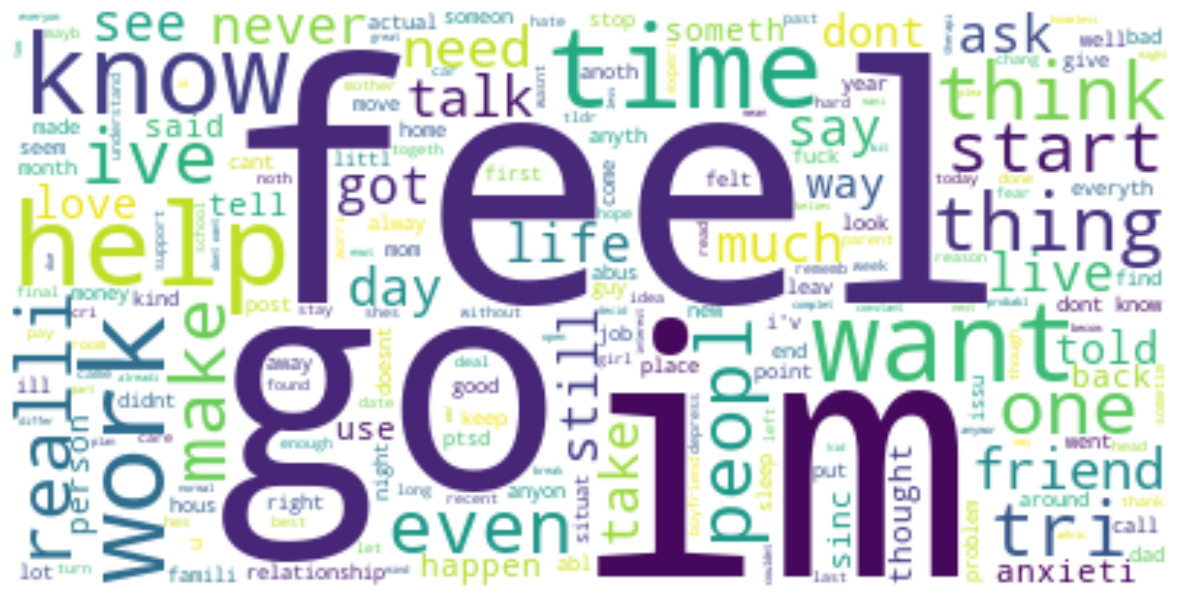

In [11]:
text=" ".join(i for i in data.text)
stopwords= set(STOPWORDS)
wordcloud= WordCloud(stopwords= stopwords, background_color="white").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Stress Model

The label column in this dataset contains labels as 0 and 1. 0 means no stress and 1 means stress. Will see Stress and No Stress lables instead of 1 and 0. So let's prepare this column accordingly and select the text and label columns for the process of training a machine learning model:

In [12]:
data["label"]= data["label"].map({0: "No Stress", 1: "Stress"})
data= data[["text", "label"]]
data.head()

,text,label
0,said felt way sugget go rest trigger ahead you...,Stress
1,hey rassist sure right place post goe im curr...,No Stress
2,mom hit newspap shock would know dont like pla...,Stress
3,met new boyfriend amaz kind sweet good student...,Stress
4,octob domest violenc awar month domest violenc...,Stress


Split this dataset into training and test sets:

In [14]:
x= np.array(data["text"])
y= np.array(data["label"])

cv= CountVectorizer()
X= cv.fit_transform(x)

xtrain, xtest, ytrain, ytest= train_test_split(X, y, test_size=0.33, random_state= 42)

As this task is based on the problem of binary classification, will be using the Bernoulli Navie Bayes algorithm, which one of the best algorithm for binary classification problems. So let's train the stress detection model:

In [16]:
model= BernoulliNB()
model.fit(xtrain, ytrain)

BernoulliNB()

Now let's test the performance of our model on some random sentence based on mental health:

In [17]:
user= input("Enter a Text: ")
data= cv.transform([user]).toarray()
output= model.predict(data)
output

Enter a Text:  People need to take care of their mental health


array(['No Stress'], dtype='<U9')

In [18]:
user= input("Enter a Text: ")
data= cv.transform([user]).toarray()
output= model.predict(data)
output

Enter a Text:  Sometimes I feel like I need some help


array(['Stress'], dtype='<U9')

So as you can see, we can see good results from our machine learning model. This is how you can train a stress detection model to detect stress from social media posts. This machine learning model can be improved by feeding it with more data.


### Summary:

So this is how you can train a machine learning model to detect stress from social media posts. People often share their feelings on social media platforms. Many organization can use stress detection to find which social media users are stressed to help them quickly. 